In [852]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
import librosa, librosa.display

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [853]:
n_cat = 167   # number of cata data
n_dog = 113   # number of dog data

In [854]:
# DataFrame for storing data
data = pd.DataFrame({"File": np.zeros(n_cat + n_dog),
                     "Label": [1] * n_cat + [0] * n_dog})
data

,File,Label
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1
...,...,...
275,0.0,0
276,0.0,0
277,0.0,0
278,0.0,0


In [855]:
# cat data
for i in range(1, n_cat + 1):
    f_name = "./data/cat/cat_" + str(i) + ".wav"
    data.loc[i - 1, "File"] = f_name

# dog data
for i in range(0, n_dog):
    f_name = "./data/dog/dog_barking_" + str(i) + ".wav"
    data.loc[i + n_cat, "File"] = f_name

data

,File,Label
0,./data/cat/cat_1.wav,1
1,./data/cat/cat_2.wav,1
2,./data/cat/cat_3.wav,1
3,./data/cat/cat_4.wav,1
4,./data/cat/cat_5.wav,1
...,...,...
275,./data/dog/dog_barking_108.wav,0
276,./data/dog/dog_barking_109.wav,0
277,./data/dog/dog_barking_110.wav,0
278,./data/dog/dog_barking_111.wav,0


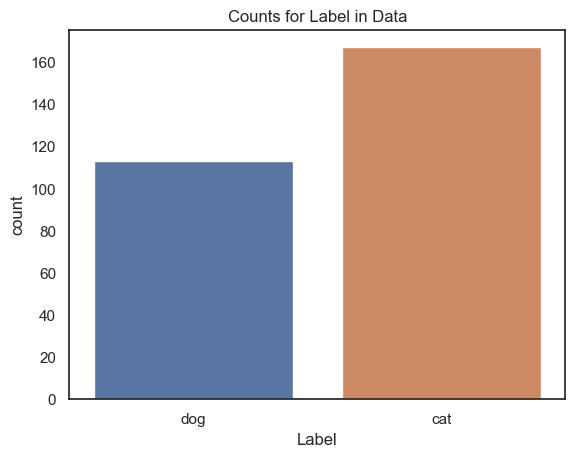

In [856]:
sns.countplot(x = data["Label"])
plt.title("Counts for Label in Data")
plt.xticks(np.arange(0, 2), labels = ["dog", "cat"])
plt.show()

## Split into train and test sets

In [857]:
# create train_data
train_data = data.sample(n = int(data.shape[0] * 0.7), replace = False)
train_data = train_data.sort_index()
train_data

,File,Label
0,./data/cat/cat_1.wav,1
2,./data/cat/cat_3.wav,1
3,./data/cat/cat_4.wav,1
5,./data/cat/cat_6.wav,1
6,./data/cat/cat_7.wav,1
...,...,...
271,./data/dog/dog_barking_104.wav,0
273,./data/dog/dog_barking_106.wav,0
275,./data/dog/dog_barking_108.wav,0
277,./data/dog/dog_barking_110.wav,0


In [858]:
# create test_data
test_data = data.iloc[data.index.difference(train_data.index)].sort_index()
test_data

,File,Label
1,./data/cat/cat_2.wav,1
4,./data/cat/cat_5.wav,1
8,./data/cat/cat_9.wav,1
9,./data/cat/cat_10.wav,1
14,./data/cat/cat_15.wav,1
...,...,...
270,./data/dog/dog_barking_103.wav,0
272,./data/dog/dog_barking_105.wav,0
274,./data/dog/dog_barking_107.wav,0
276,./data/dog/dog_barking_109.wav,0


In [859]:
train_data.value_counts("Label")

Label
1    119
0     77
Name: count, dtype: int64

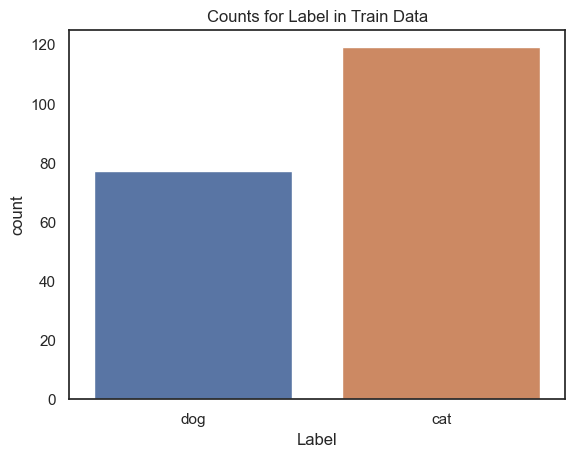

In [860]:
sns.countplot(x = train_data["Label"])
plt.title("Counts for Label in Train Data")
plt.xticks(np.arange(0, 2), labels = ["dog", "cat"])
plt.show()

## Preprocessing

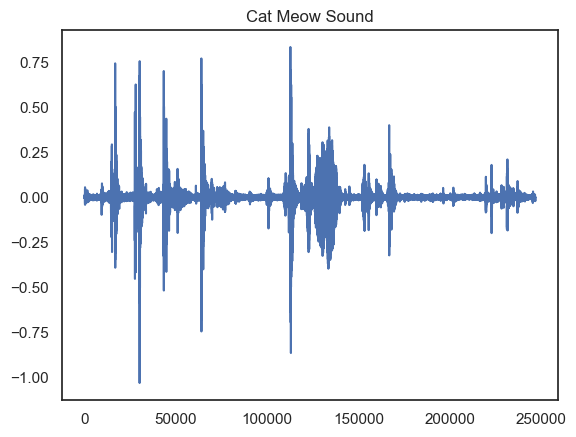

In [861]:
signal, sr = librosa.load(train_data.loc[0]["File"], sr = 22050)

plt.plot(signal)
plt.title("Cat Meow Sound")
plt.show()

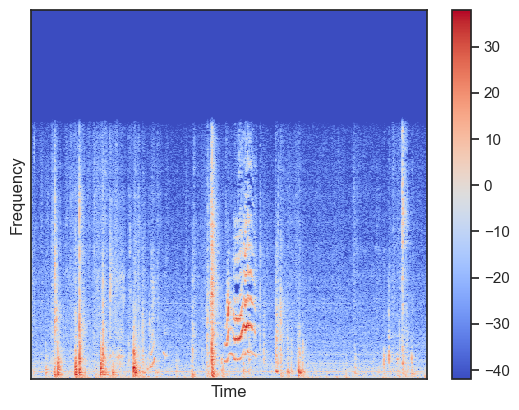

In [749]:
stft = librosa.core.stft(signal, hop_length = 512, n_fft = 2048)
spectogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectrogram, sr = sr, hop_length = 512)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [750]:
def extract_features(directory):
    signal, sr = librosa.load(directory, sr = 22050)
    mfccs = np.mean(librosa.feature.mfcc(y = signal, sr = sr, n_mfcc = 100).T, axis = 0)
    return mfccs

In [751]:
X_train = []
y_train = []
for file in train_data["File"]:
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    X_train.append(extract_features(file))
    y_train.append(train_data.loc[train_data["File"] == file, "Label"].values[0])

In [752]:
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)
# X_train.shape
# y_train.shape

In [753]:
X_test = []
y_test = []
for file in test_data["File"]:
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    X_test.append(extract_features(file))
    y_test.append(test_data.loc[test_data["File"] == file, "Label"].values[0])

In [754]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)
# X_test.shape
# y_test.shape

## Modeling

Standard Neural Network

In [886]:
model = Sequential()
model.add(Dense(input_shape = (100, ), units = 200, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [887]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [888]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 1.9916 - accuracy: 0.5337
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0124 - accuracy: 0.5959
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7380 - accuracy: 0.5596
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5078
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.5389
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.5233
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.5648
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.5648
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5389
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.5337
Epoch 11/100
7/7 [===========

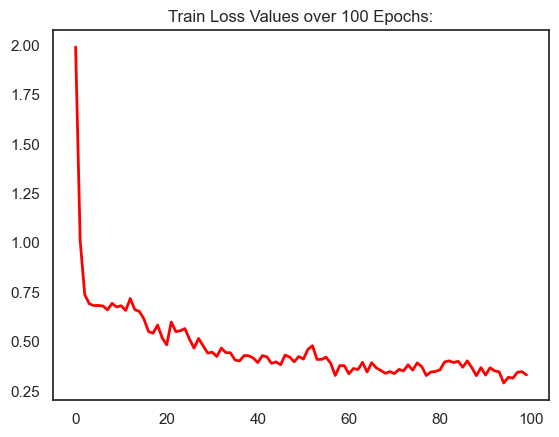

In [889]:
plt.title('Train Loss Values over 100 Epochs:')
plt.plot(hist.history['loss'], color = 'red', linewidth = 2)
plt.show()

Prediction

In [890]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [891]:
y_pred = (y_pred > 0.5) * 1

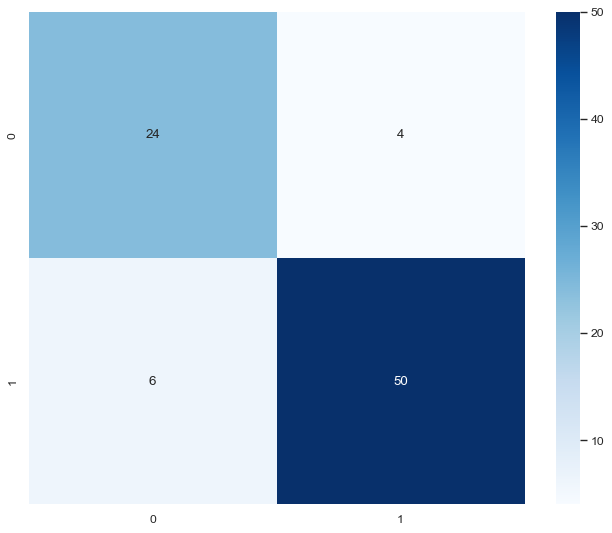

In [892]:
plt.figure(figsize = (10, 8), dpi = 80)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = 'Blues')
plt.show()

In [893]:
(24 + 50) / (24 + 4 + 6 + 50)

0.8809523809523809

In [894]:
MSE = np.mean((y_pred - y_test) ** 2)
MSE

0.11904761904761904

In [911]:
model = Sequential()
model.add(Dense(input_shape = (100, ), units = 200, activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [912]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [913]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
7/7 [==============================] - 1s 4ms/step - loss: 3.6803 - accuracy: 0.5648
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 1.6704 - accuracy: 0.7254
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 1.8150 - accuracy: 0.7306
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 2.1333 - accuracy: 0.7306
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 1.0641 - accuracy: 0.7927
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.9261 - accuracy: 0.8135
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.9998 - accuracy: 0.7617
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.8342
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 0.8756
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.8290
Epoch 11/100
7/7 [===========

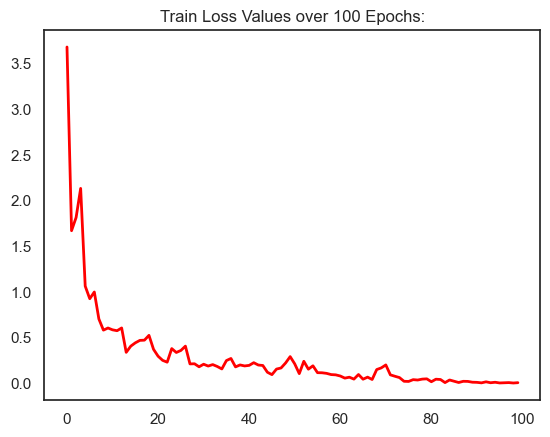

In [914]:
plt.title('Train Loss Values over 100 Epochs:')
plt.plot(hist.history['loss'], color = 'red', linewidth = 2)
plt.show()

In [915]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [916]:
y_pred = (y_pred > 0.5) * 1

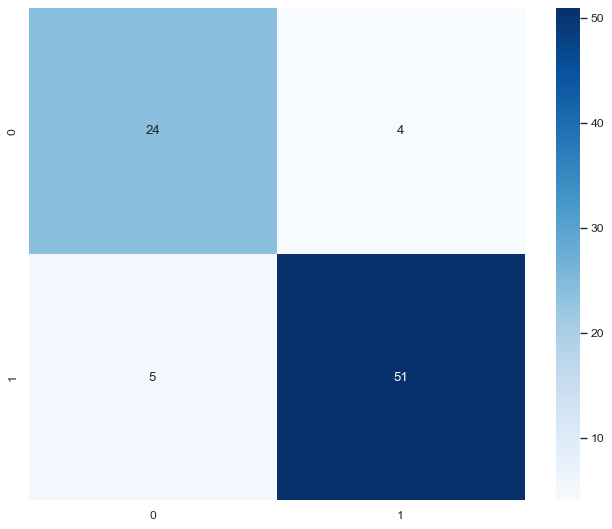

In [917]:
plt.figure(figsize = (10, 8), dpi = 80)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = 'Blues')
plt.show()

In [918]:
(24 + 51) / (24 + 4 + 5 + 50)

0.9036144578313253

In [919]:
MSE = np.mean((y_pred - y_test) ** 2)
MSE

0.10714285714285714

CNN

In [551]:
def create_spectogram(file):
  
  signal, sr = librosa.load(file)
  X = librosa.stft(signal)
  Xdb = librosa.amplitude_to_db(abs(X))
  
  # plotting
  librosa.display.specshow(Xdb, sr = sr, y_axis = "hz")
  plt.ylabel("")
  plt.axis("off")
  
  # save plot
  image_file = file[:7] + "spectogram/" + file[11:-4] + ".jpg"
  plt.savefig(image_file, bbox_inches = 'tight', pad_inches = 0)

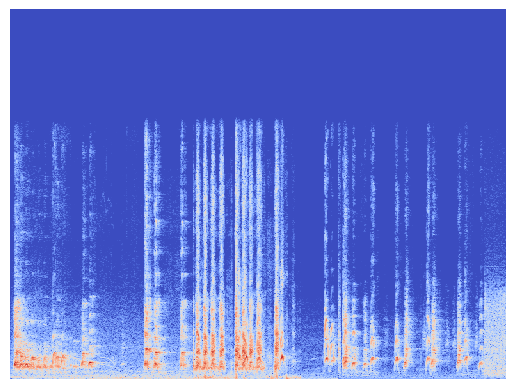

In [554]:
os.mkdir("./data/spectogram")

for file in train_data["File"]:
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    create_spectogram(file)
    
for file in test_data["File"]:
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    create_spectogram(file)

In [862]:
os.mkdir("./data/spectogram/cat")
os.mkdir("./data/spectogram/dog")

In [865]:
file = train_data["File"][0]


'./data/spectogram/cat/cat_1.jpg'

In [866]:
for file in train_data["File"]:
    f_name = file[:7] + "spectogram/" + file[11:-4] + ".jpg"
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    os.replace(f_name, file[:7] + "spectogram/" + file[7:-4] + ".jpg")

In [867]:
for file in test_data["File"]:
    f_name = file[:7] + "spectogram/" + file[11:-4] + ".jpg"
    if file in ("./data/cat/cat_104.wav",
                "./data/cat/cat_111.wav",
                "./data/cat/cat_145.wav"):
        continue
    os.replace(f_name, file[:7] + "spectogram/" + file[7:-4] + ".jpg")

In [868]:
width = 128
height = 128
datagen = ImageDataGenerator(rescale = 1 / 255.0, validation_split = 0.2)

In [870]:
trainDatagen = datagen.flow_from_directory(directory = './data/spectogram',
                                           target_size = (width, height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset = 'training')

valDatagen = datagen.flow_from_directory(directory = './data/spectogram',
                                         target_size = (width, height),
                                         class_mode = 'binary',
                                         batch_size = 16,
                                         subset = "validation")

Found 223 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


In [883]:
model = Sequential([
    Conv2D(40, (3, 3), activation = 'relu', input_shape = (128, 128, 3)),
    MaxPool2D(2, 2),
    Dropout(0.3),
                    
    Conv2D(80, (3, 3), activation = 'relu'),
    MaxPool2D(2, 2),
    Dropout(0.3),
                  
    Conv2D(160, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    Dropout(0.3),
    
    Conv2D(160, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    Dropout(0.3),
    Flatten(),
                    
    Dense(200, activation = 'relu', kernel_initializer = 'normal'),
    Dropout(0.2),
    Dense(200, activation = 'relu', kernel_initializer = 'normal'), 
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

In [884]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(trainDatagen, epochs = 10, batch_size = 32, validation_data = valDatagen)

Epoch 1/10
14/14 [==============================] - 7s 458ms/step - loss: 0.7737 - accuracy: 0.5247 - val_loss: 0.6890 - val_accuracy: 0.5926
Epoch 2/10
14/14 [==============================] - 6s 402ms/step - loss: 0.6689 - accuracy: 0.5964 - val_loss: 0.6847 - val_accuracy: 0.5926
Epoch 3/10
14/14 [==============================] - 3s 238ms/step - loss: 0.5978 - accuracy: 0.6502 - val_loss: 0.7211 - val_accuracy: 0.6481
Epoch 4/10
14/14 [==============================] - 4s 301ms/step - loss: 0.4281 - accuracy: 0.8430 - val_loss: 1.0202 - val_accuracy: 0.6481
Epoch 5/10
14/14 [==============================] - 4s 250ms/step - loss: 0.3607 - accuracy: 0.8655 - val_loss: 0.8398 - val_accuracy: 0.6667
Epoch 6/10
14/14 [==============================] - 4s 293ms/step - loss: 0.3989 - accuracy: 0.8072 - val_loss: 0.8555 - val_accuracy: 0.7778
Epoch 7/10
14/14 [==============================] - 4s 251ms/step - loss: 0.2903 - accuracy: 0.9372 - val_loss: 0.5902 - val_accuracy: 0.8519
Epoch 

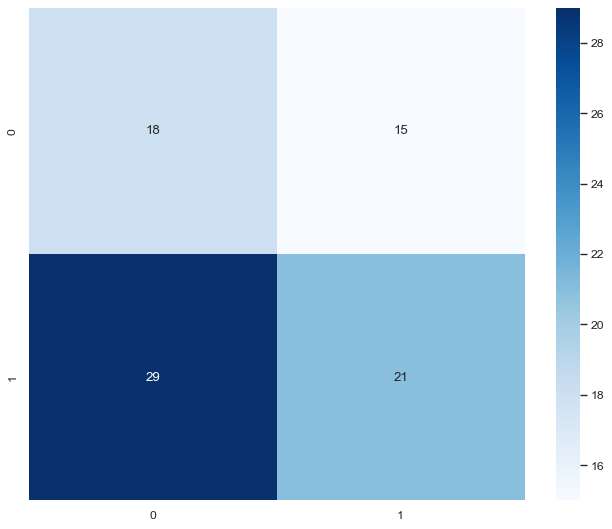

In [722]:
plt.figure(figsize = (10,8), dpi = 80)
heatmap = sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,cmap='Blues')
plt.show()